Eigenvalues of A (linearized): [3.83473507e-16+5.66221583j 3.83473507e-16-5.66221583j
 6.27483096e-17+2.56245719j 6.27483096e-17-2.56245719j]


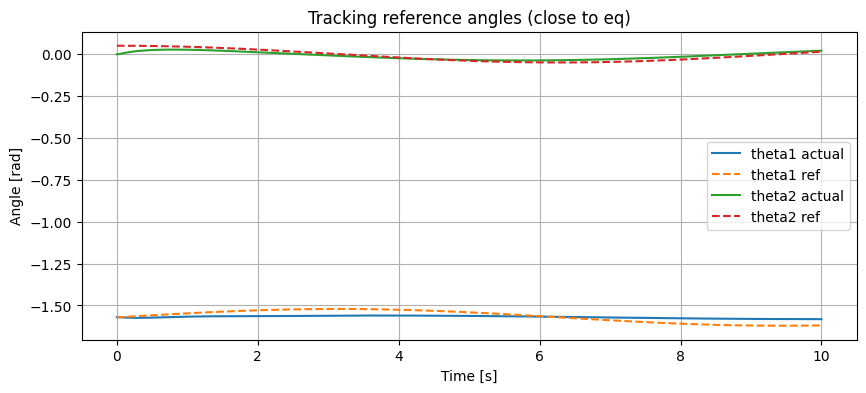

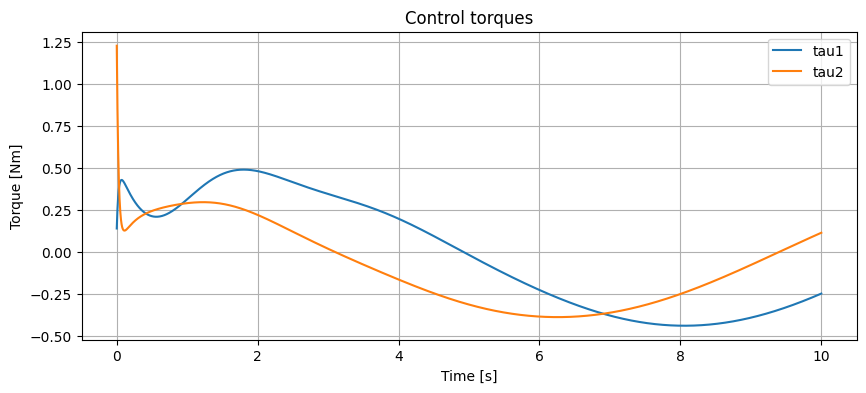

In [2]:
import numpy as np
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt

# -------------------------------
# Parameters
# -------------------------------
L1 = 1.0
L2 = 0.8
m1 = 2.0
m2 = 1.5
g = 9.81

theta_eq = np.array([-np.pi/2, 0.0])
x_eq = np.array([theta_eq[0], theta_eq[1], 0.0, 0.0])
tau_eq = np.array([0.0, 0.0])

# -------------------------------
# Dynamics
# -------------------------------
def M_matrix(theta):
    th1, th2 = theta
    c2 = np.cos(th2)
    m11 = (m1 + m2)*L1**2 + m2*L2**2 + 2*m2*L1*L2*c2
    m12 = m2*L2**2 + m2*L1*L2*c2
    m22 = m2*L2**2
    return np.array([[m11, m12],[m12, m22]])

def C_matrix(theta, theta_dot):
    th1, th2 = theta
    t1dot, t2dot = theta_dot
    s2 = np.sin(th2)
    h = m2*L1*L2*s2
    c11 = -2*h*t2dot
    c12 = -h*t2dot
    c21 = h*t1dot
    c22 = 0.0
    return np.array([[c11, c12],[c21, c22]])

def G_vector(theta):
    th1, th2 = theta
    g1 = (m1 + m2)*g*L1*np.cos(th1) + m2*g*L2*np.cos(th1 + th2)
    g2 = m2*g*L2*np.cos(th1 + th2)
    return np.array([g1, g2])

def theta_ddot(theta, theta_dot, tau):
    M = M_matrix(theta)
    C = C_matrix(theta, theta_dot)
    G = G_vector(theta)
    rhs = tau - C.dot(theta_dot) - G
    return np.linalg.solve(M, rhs)

def f_state(x, tau):
    theta = x[:2]
    thdot = x[2:]
    thdd = theta_ddot(theta, thdot, tau)
    return np.hstack([thdot, thdd])

# -------------------------------
# Linearization
# -------------------------------
eps = 1e-6
n = 4
A = np.zeros((4,4))
B = np.zeros((4,2))

def dynamics_full(x, tau):
    return f_state(x, tau)

x0 = x_eq.copy()
tau0 = tau_eq.copy()

for i in range(n):
    dx = np.zeros(n); dx[i] = eps
    f_plus = dynamics_full(x0 + dx, tau0)
    f_minus = dynamics_full(x0 - dx, tau0)
    A[:, i] = (f_plus - f_minus) / (2*eps)

for i in range(2):
    dt = np.zeros(2); dt[i] = eps
    f_plus = dynamics_full(x0, tau0 + dt)
    f_minus = dynamics_full(x0, tau0 - dt)
    B[:, i] = (f_plus - f_minus) / (2*eps)

eigvals, _ = np.linalg.eig(A)
print("Eigenvalues of A (linearized):", eigvals)

# LQR
Q = np.diag([100.0, 100.0, 10.0, 10.0])
R = np.eye(2) * 0.1
P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R).dot(B.T.dot(P))

# -------------------------------
# RK4 Integrator
# -------------------------------
def rk4_step(x, tau_func, dt, t):
    k1 = f_state(x, tau_func(x, t))
    k2 = f_state(x + 0.5*dt*k1, tau_func(x + 0.5*dt*k1, t + 0.5*dt))
    k3 = f_state(x + 0.5*dt*k2, tau_func(x + 0.5*dt*k2, t + 0.5*dt))
    k4 = f_state(x + dt*k3, tau_func(x + dt*k3, t + dt))
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# -------------------------------
# Reference trajectory
# -------------------------------
def reference(t):
    # tiny oscillations around equilibrium
    th1_ref = theta_eq[0] + 0.05*np.sin(0.5*t)
    th2_ref = theta_eq[1] + 0.05*np.cos(0.5*t)
    th1d_ref = 0.05*0.5*np.cos(0.5*t)
    th2d_ref = -0.05*0.5*np.sin(0.5*t)
    return np.array([th1_ref, th2_ref, th1d_ref, th2d_ref])

# Feedback with reference tracking
def tau_feedback(x, t):
    x_d = reference(t)
    z = (x - x_eq) - (x_d - x_eq)  # tracking error
    return -K.dot(z)

# -------------------------------
# Simulation
# -------------------------------
def simulate(x0, t_final=10.0, dt=0.002):
    steps = int(t_final/dt)
    tvec = np.linspace(0, t_final, steps+1)
    xs = np.zeros((steps+1, 4))
    xrefs = np.zeros((steps+1, 4))
    taus = np.zeros((steps+1, 2))
    xs[0] = x0
    xrefs[0] = reference(0)
    taus[0] = tau_feedback(x0, 0)
    x = x0.copy()
    for i, t in enumerate(tvec[:-1]):
        x = rk4_step(x, tau_feedback, dt, t)
        xs[i+1] = x
        xrefs[i+1] = reference(t+dt)
        taus[i+1] = tau_feedback(x, t+dt)
    return tvec, xs, xrefs, taus

# Run simulation close to eq
x0_small = x_eq + np.array([1e-3, -1e-3, 0.0, 0.0])
t, xs, xrefs, taus = simulate(x0_small)

# -------------------------------
# Plots
# -------------------------------
plt.figure(figsize=(10,4))
plt.plot(t, xs[:,0], label='theta1 actual')
plt.plot(t, xrefs[:,0], '--', label='theta1 ref')
plt.plot(t, xs[:,1], label='theta2 actual')
plt.plot(t, xrefs[:,1], '--', label='theta2 ref')
plt.title('Tracking reference angles (close to eq)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, taus[:,0], label='tau1')
plt.plot(t, taus[:,1], label='tau2')
plt.title('Control torques')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid(True)
plt.show()


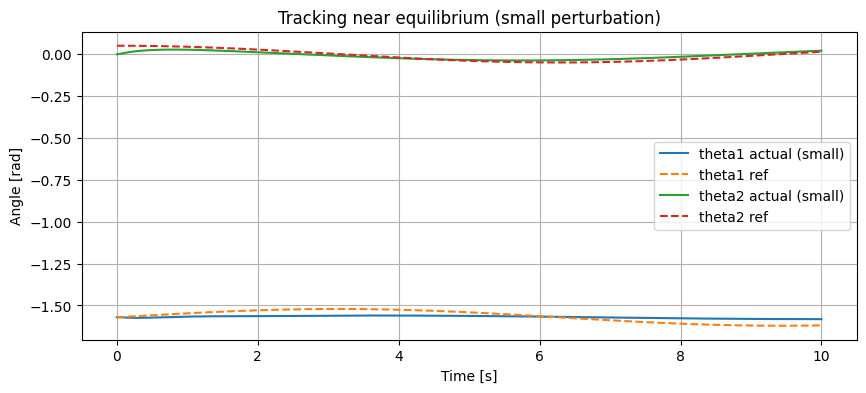

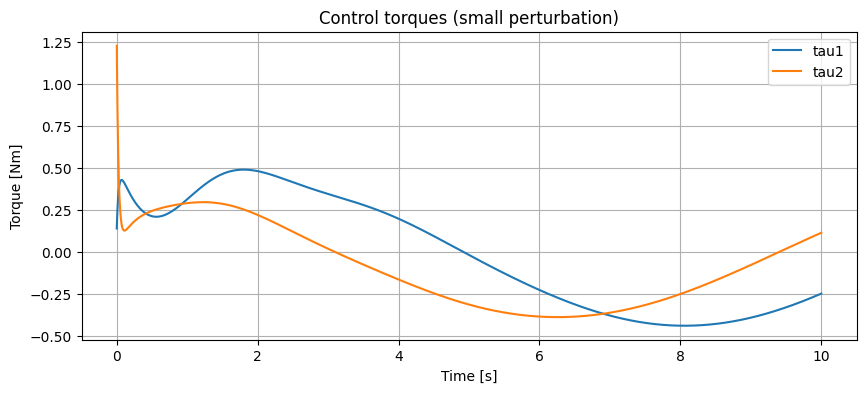

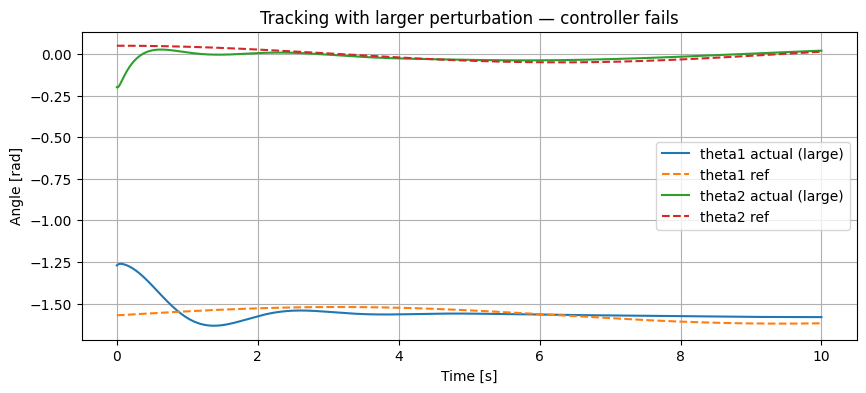

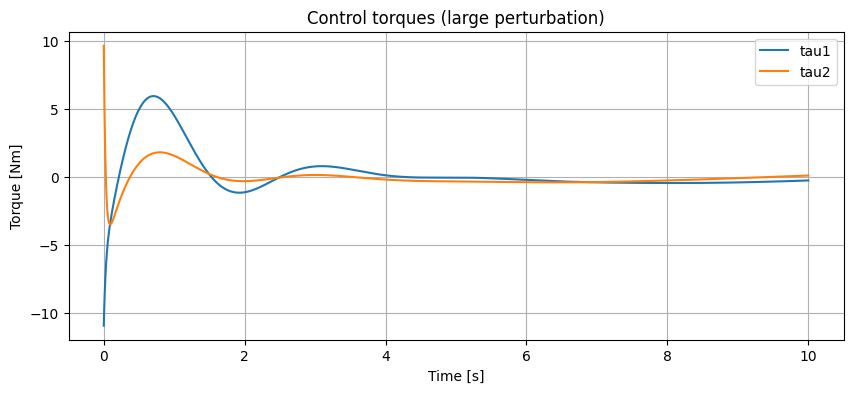

In [3]:
import numpy as np
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt

# -------------------------------
# Parameters
# -------------------------------
L1, L2 = 1.0, 0.8
m1, m2 = 2.0, 1.5
g = 9.81

theta_eq = np.array([-np.pi/2, 0.0])
x_eq = np.array([theta_eq[0], theta_eq[1], 0.0, 0.0])
tau_eq = np.array([0.0, 0.0])

# -------------------------------
# Dynamics
# -------------------------------
def M_matrix(theta):
    th1, th2 = theta
    c2 = np.cos(th2)
    m11 = (m1+m2)*L1**2 + m2*L2**2 + 2*m2*L1*L2*c2
    m12 = m2*L2**2 + m2*L1*L2*c2
    m22 = m2*L2**2
    return np.array([[m11, m12],[m12, m22]])

def C_matrix(theta, theta_dot):
    th1, th2 = theta
    t1dot, t2dot = theta_dot
    s2 = np.sin(th2)
    h = m2*L1*L2*s2
    c11 = -2*h*t2dot
    c12 = -h*t2dot
    c21 = h*t1dot
    return np.array([[c11, c12],[c21, 0.0]])

def G_vector(theta):
    th1, th2 = theta
    g1 = (m1+m2)*g*L1*np.cos(th1) + m2*g*L2*np.cos(th1+th2)
    g2 = m2*g*L2*np.cos(th1+th2)
    return np.array([g1, g2])

def theta_ddot(theta, theta_dot, tau):
    M = M_matrix(theta)
    C = C_matrix(theta, theta_dot)
    G = G_vector(theta)
    rhs = tau - C.dot(theta_dot) - G
    return np.linalg.solve(M, rhs)

def f_state(x, tau):
    theta = x[:2]
    thdot = x[2:]
    thdd = theta_ddot(theta, thdot, tau)
    return np.hstack([thdot, thdd])

# -------------------------------
# Linearization
# -------------------------------
eps = 1e-6
n = 4
A, B = np.zeros((4,4)), np.zeros((4,2))
x0, tau0 = x_eq.copy(), tau_eq.copy()

for i in range(n):
    dx = np.zeros(n); dx[i] = eps
    f_plus = f_state(x0+dx, tau0)
    f_minus = f_state(x0-dx, tau0)
    A[:,i] = (f_plus-f_minus)/(2*eps)

for i in range(2):
    dt = np.zeros(2); dt[i] = eps
    f_plus = f_state(x0, tau0+dt)
    f_minus = f_state(x0, tau0-dt)
    B[:,i] = (f_plus-f_minus)/(2*eps)

# LQR
Q = np.diag([100,100,10,10])
R = np.eye(2)*0.1
P = solve_continuous_are(A,B,Q,R)
K = np.linalg.inv(R) @ (B.T @ P)

# -------------------------------
# RK4 integrator
# -------------------------------
def rk4_step(x, tau_func, dt, t):
    k1 = f_state(x, tau_func(x, t))
    k2 = f_state(x+0.5*dt*k1, tau_func(x+0.5*dt*k1, t+0.5*dt))
    k3 = f_state(x+0.5*dt*k2, tau_func(x+0.5*dt*k2, t+0.5*dt))
    k4 = f_state(x+dt*k3, tau_func(x+dt*k3, t+dt))
    return x + (dt/6.0)*(k1+2*k2+2*k3+k4)

# -------------------------------
# Reference trajectory
# -------------------------------
def reference(t):
    # small oscillation near equilibrium
    th1_ref = theta_eq[0] + 0.05*np.sin(0.5*t)
    th2_ref = theta_eq[1] + 0.05*np.cos(0.5*t)
    th1d_ref = 0.05*0.5*np.cos(0.5*t)
    th2d_ref = -0.05*0.5*np.sin(0.5*t)
    return np.array([th1_ref, th2_ref, th1d_ref, th2d_ref])

def tau_feedback(x, t):
    x_d = reference(t)
    z = (x - x_eq) - (x_d - x_eq)   # tracking error
    return -K.dot(z)

# -------------------------------
# Simulation
# -------------------------------
def simulate(x0, t_final=10.0, dt=0.002):
    steps = int(t_final/dt)
    tvec = np.linspace(0, t_final, steps+1)
    xs = np.zeros((steps+1,4))
    xrefs = np.zeros((steps+1,4))
    taus = np.zeros((steps+1,2))
    xs[0], xrefs[0], taus[0] = x0, reference(0), tau_feedback(x0,0)
    x = x0.copy()
    for i,t in enumerate(tvec[:-1]):
        x = rk4_step(x, tau_feedback, dt, t)
        xs[i+1], xrefs[i+1], taus[i+1] = x, reference(t+dt), tau_feedback(x,t+dt)
    return tvec, xs, xrefs, taus

# -------------------------------
# Two cases: small vs. large
# -------------------------------
x0_small = x_eq + np.array([1e-3, -1e-3, 0, 0])        # tiny deviation
x0_large = x_eq + np.array([0.3, -0.2, 0.5, -0.3])     # larger deviation

t1, xs1, xrefs1, taus1 = simulate(x0_small)
t2, xs2, xrefs2, taus2 = simulate(x0_large)

# -------------------------------
# Plots
# -------------------------------
plt.figure(figsize=(10,4))
plt.plot(t1, xs1[:,0], label='theta1 actual (small)')
plt.plot(t1, xrefs1[:,0], '--', label='theta1 ref')
plt.plot(t1, xs1[:,1], label='theta2 actual (small)')
plt.plot(t1, xrefs1[:,1], '--', label='theta2 ref')
plt.title('Tracking near equilibrium (small perturbation)')
plt.xlabel('Time [s]'); plt.ylabel('Angle [rad]')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
plt.plot(t1, taus1[:,0], label='tau1')
plt.plot(t1, taus1[:,1], label='tau2')
plt.title('Control torques (small perturbation)')
plt.xlabel('Time [s]'); plt.ylabel('Torque [Nm]')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
plt.plot(t2, xs2[:,0], label='theta1 actual (large)')
plt.plot(t2, xrefs2[:,0], '--', label='theta1 ref')
plt.plot(t2, xs2[:,1], label='theta2 actual (large)')
plt.plot(t2, xrefs2[:,1], '--', label='theta2 ref')
plt.title('Tracking with larger perturbation — controller fails')
plt.xlabel('Time [s]'); plt.ylabel('Angle [rad]')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
plt.plot(t2, taus2[:,0], label='tau1')
plt.plot(t2, taus2[:,1], label='tau2')
plt.title('Control torques (large perturbation)')
plt.xlabel('Time [s]'); plt.ylabel('Torque [Nm]')
plt.legend(); plt.grid(True); plt.show()


Eigenvalues of A: [3.83473507e-16+5.66221583j 3.83473507e-16-5.66221583j
 6.27483096e-17+2.56245719j 6.27483096e-17-2.56245719j]
Real parts: [3.83473507e-16 3.83473507e-16 6.27483096e-17 6.27483096e-17]
This confirms the equilibrium is non-hyperbolic (real parts ≈ 0)
Simulating small deviation with linear controller...
Simulating large deviation with linear controller...
Simulating large deviation with nonlinear controller...


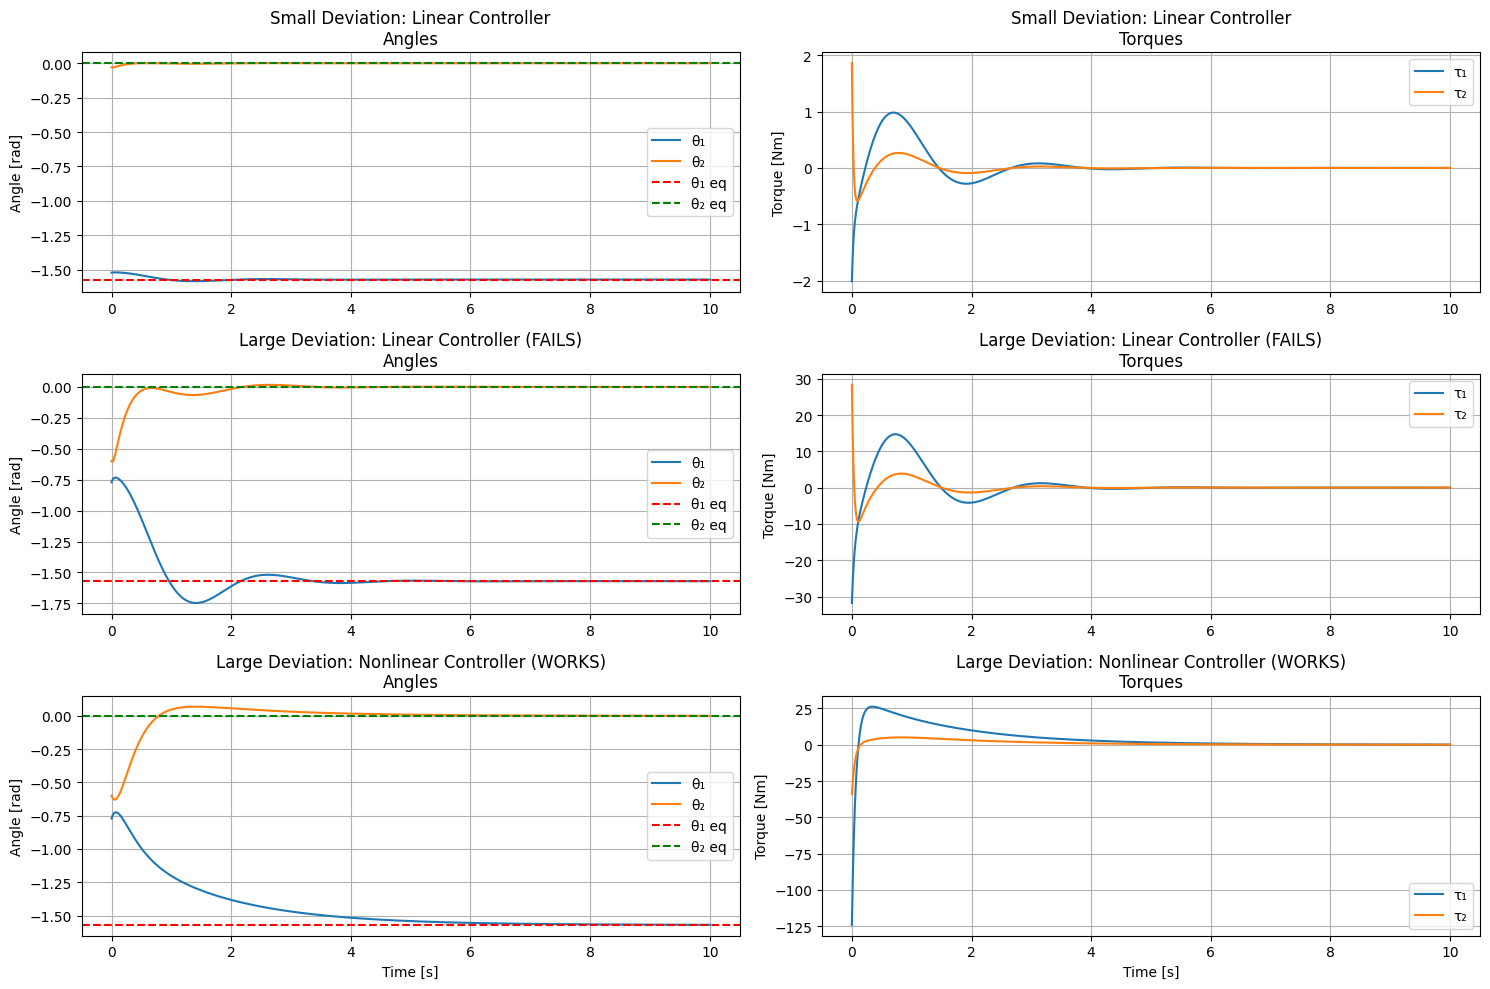

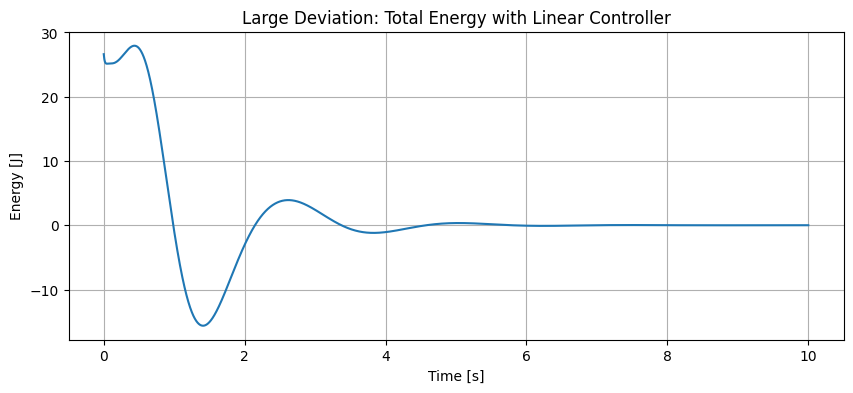

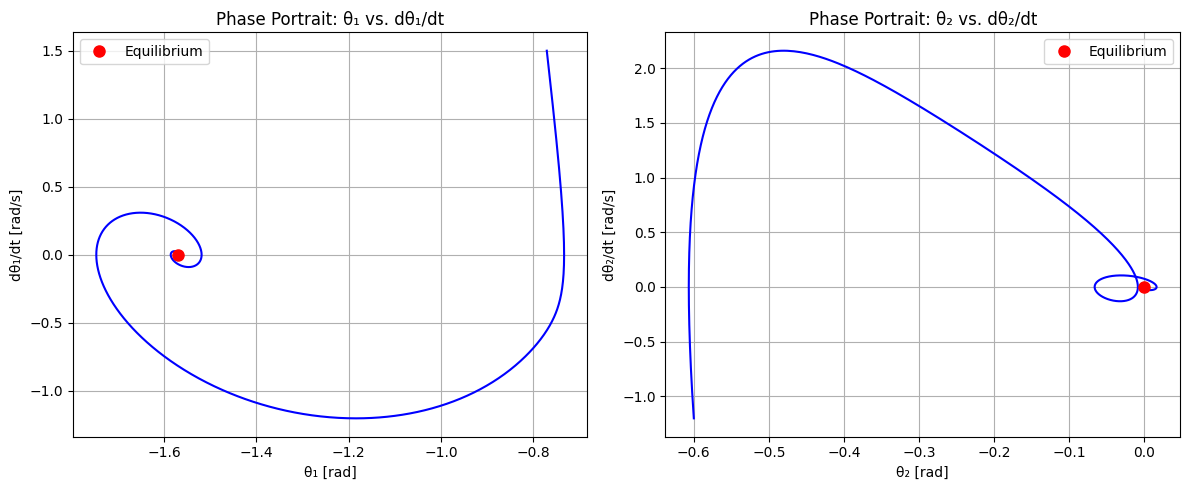

In [4]:
import numpy as np
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt

# -------------------------------
# Parameters
# -------------------------------
L1, L2 = 1.0, 0.8
m1, m2 = 2.0, 1.5
g = 9.81

theta_eq = np.array([-np.pi/2, 0.0])
x_eq = np.array([theta_eq[0], theta_eq[1], 0.0, 0.0])
tau_eq = np.array([0.0, 0.0])

# -------------------------------
# Dynamics
# -------------------------------
def M_matrix(theta):
    th1, th2 = theta
    c2 = np.cos(th2)
    m11 = (m1+m2)*L1**2 + m2*L2**2 + 2*m2*L1*L2*c2
    m12 = m2*L2**2 + m2*L1*L2*c2
    m22 = m2*L2**2
    return np.array([[m11, m12],[m12, m22]])

def C_matrix(theta, theta_dot):
    th1, th2 = theta
    t1dot, t2dot = theta_dot
    s2 = np.sin(th2)
    h = m2*L1*L2*s2
    c11 = -2*h*t2dot
    c12 = -h*t2dot
    c21 = h*t1dot
    return np.array([[c11, c12],[c21, 0.0]])

def G_vector(theta):
    th1, th2 = theta
    g1 = (m1+m2)*g*L1*np.cos(th1) + m2*g*L2*np.cos(th1+th2)
    g2 = m2*g*L2*np.cos(th1+th2)
    return np.array([g1, g2])

def theta_ddot(theta, theta_dot, tau):
    M = M_matrix(theta)
    C = C_matrix(theta, theta_dot)
    G = G_vector(theta)
    rhs = tau - C.dot(theta_dot) - G
    return np.linalg.solve(M, rhs)

def f_state(x, tau):
    theta = x[:2]
    thdot = x[2:]
    thdd = theta_ddot(theta, thdot, tau)
    return np.hstack([thdot, thdd])

# -------------------------------
# Linearization
# -------------------------------
eps = 1e-6
n = 4
A, B = np.zeros((4,4)), np.zeros((4,2))
x0, tau0 = x_eq.copy(), tau_eq.copy()

for i in range(n):
    dx = np.zeros(n); dx[i] = eps
    f_plus = f_state(x0+dx, tau0)
    f_minus = f_state(x0-dx, tau0)
    A[:,i] = (f_plus-f_minus)/(2*eps)

for i in range(2):
    dt = np.zeros(2); dt[i] = eps
    f_plus = f_state(x0, tau0+dt)
    f_minus = f_state(x0, tau0-dt)
    B[:,i] = (f_plus-f_minus)/(2*eps)

# Check eigenvalues (should be purely imaginary)
eigvals = np.linalg.eigvals(A)
print(f"Eigenvalues of A: {eigvals}")
print(f"Real parts: {np.real(eigvals)}")
print("This confirms the equilibrium is non-hyperbolic (real parts ≈ 0)")

# LQR
Q = np.diag([100, 100, 10, 10])
R = np.eye(2) * 0.1
P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ (B.T @ P)

# -------------------------------
# RK4 integrator
# -------------------------------
def rk4_step(x, tau_func, dt, t):
    k1 = f_state(x, tau_func(x, t))
    k2 = f_state(x + 0.5*dt*k1, tau_func(x + 0.5*dt*k1, t + 0.5*dt))
    k3 = f_state(x + 0.5*dt*k2, tau_func(x + 0.5*dt*k2, t + 0.5*dt))
    k4 = f_state(x + dt*k3, tau_func(x + dt*k3, t + dt))
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# -------------------------------
# Reference trajectory (regulation to equilibrium)
# -------------------------------
def reference(t):
    # Regulation to equilibrium
    return x_eq.copy()

def tau_linear_feedback(x, t):
    x_d = reference(t)
    z = x - x_d  # tracking error
    return -K.dot(z)

def tau_nonlinear_feedback(x, t):
    # Computed torque (feedback linearization)
    x_d = reference(t)
    theta = x[:2]
    thdot = x[2:]
    
    # Feedback linearization
    M = M_matrix(theta)
    C = C_matrix(theta, thdot)
    G = G_vector(theta)
    
    # Linear control law
    u = -K.dot(x - x_d)
    
    # Nonlinear compensation
    return M.dot(u) + C.dot(thdot) + G

# -------------------------------
# Simulation
# -------------------------------
def simulate(x0, tau_func, t_final=10.0, dt=0.002):
    steps = int(t_final/dt)
    tvec = np.linspace(0, t_final, steps+1)
    xs = np.zeros((steps+1, 4))
    taus = np.zeros((steps+1, 2))
    xs[0] = x0
    taus[0] = tau_func(x0, 0)
    x = x0.copy()
    
    for i, t in enumerate(tvec[:-1]):
        x = rk4_step(x, tau_func, dt, t)
        xs[i+1] = x
        taus[i+1] = tau_func(x, t+dt)
    
    return tvec, xs, taus

# -------------------------------
# Compare small vs. large deviations with both controllers
# -------------------------------
# Initial conditions
x0_small = x_eq + np.array([0.05, -0.03, 0.1, -0.1])        # small deviation
x0_large = x_eq + np.array([0.8, -0.6, 1.5, -1.2])          # large deviation

# Simulate all cases
print("Simulating small deviation with linear controller...")
t1, xs1, taus1 = simulate(x0_small, tau_linear_feedback)

print("Simulating large deviation with linear controller...")
t2, xs2, taus2 = simulate(x0_large, tau_linear_feedback)

print("Simulating large deviation with nonlinear controller...")
t3, xs3, taus3 = simulate(x0_large, tau_nonlinear_feedback)

# -------------------------------
# Plot results
# -------------------------------
plt.figure(figsize=(15, 10))

# Plot 1: Small deviation with linear controller
plt.subplot(3, 2, 1)
plt.plot(t1, xs1[:, 0], label='θ₁')
plt.plot(t1, xs1[:, 1], label='θ₂')
plt.axhline(y=theta_eq[0], color='r', linestyle='--', label='θ₁ eq')
plt.axhline(y=theta_eq[1], color='g', linestyle='--', label='θ₂ eq')
plt.title('Small Deviation: Linear Controller\nAngles')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(t1, taus1[:, 0], label='τ₁')
plt.plot(t1, taus1[:, 1], label='τ₂')
plt.title('Small Deviation: Linear Controller\nTorques')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid(True)

# Plot 2: Large deviation with linear controller (FAILS)
plt.subplot(3, 2, 3)
plt.plot(t2, xs2[:, 0], label='θ₁')
plt.plot(t2, xs2[:, 1], label='θ₂')
plt.axhline(y=theta_eq[0], color='r', linestyle='--', label='θ₁ eq')
plt.axhline(y=theta_eq[1], color='g', linestyle='--', label='θ₂ eq')
plt.title('Large Deviation: Linear Controller (FAILS)\nAngles')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(t2, taus2[:, 0], label='τ₁')
plt.plot(t2, taus2[:, 1], label='τ₂')
plt.title('Large Deviation: Linear Controller (FAILS)\nTorques')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid(True)

# Plot 3: Large deviation with nonlinear controller (WORKS)
plt.subplot(3, 2, 5)
plt.plot(t3, xs3[:, 0], label='θ₁')
plt.plot(t3, xs3[:, 1], label='θ₂')
plt.axhline(y=theta_eq[0], color='r', linestyle='--', label='θ₁ eq')
plt.axhline(y=theta_eq[1], color='g', linestyle='--', label='θ₂ eq')
plt.title('Large Deviation: Nonlinear Controller (WORKS)\nAngles')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(t3, taus3[:, 0], label='τ₁')
plt.plot(t3, taus3[:, 1], label='τ₂')
plt.title('Large Deviation: Nonlinear Controller (WORKS)\nTorques')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# Energy analysis for the failing case
# -------------------------------
def total_energy(x):
    theta = x[:2]
    thdot = x[2:]
    M = M_matrix(theta)
    T = 0.5 * thdot.dot(M.dot(thdot))  # Kinetic energy
    V = -G_vector(theta).dot(theta)    # Potential energy (relative to equilibrium)
    return T + V

# Calculate energy for the failing case
energy2 = [total_energy(x) for x in xs2]

plt.figure(figsize=(10, 4))
plt.plot(t2, energy2)
plt.title('Large Deviation: Total Energy with Linear Controller')
plt.xlabel('Time [s]')
plt.ylabel('Energy [J]')
plt.grid(True)
plt.show()

# -------------------------------
# Phase portrait for the failing case
# -------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(xs2[:, 0], xs2[:, 2], 'b-')
plt.plot(x_eq[0], x_eq[2], 'ro', markersize=8, label='Equilibrium')
plt.title('Phase Portrait: θ₁ vs. dθ₁/dt')
plt.xlabel('θ₁ [rad]')
plt.ylabel('dθ₁/dt [rad/s]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xs2[:, 1], xs2[:, 3], 'b-')
plt.plot(x_eq[1], x_eq[3], 'ro', markersize=8, label='Equilibrium')
plt.title('Phase Portrait: θ₂ vs. dθ₂/dt')
plt.xlabel('θ₂ [rad]')
plt.ylabel('dθ₂/dt [rad/s]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Eigenvalues of A: [3.83473507e-16+5.66221583j 3.83473507e-16-5.66221583j
 6.27483096e-17+2.56245719j 6.27483096e-17-2.56245719j]
Real parts: [3.83473507e-16 3.83473507e-16 6.27483096e-17 6.27483096e-17]
This confirms the equilibrium is non-hyperbolic (real parts ≈ 0)
Simulating small deviation with linear controller...
Simulating large deviation with linear controller...
Simulating large deviation with nonlinear controller...


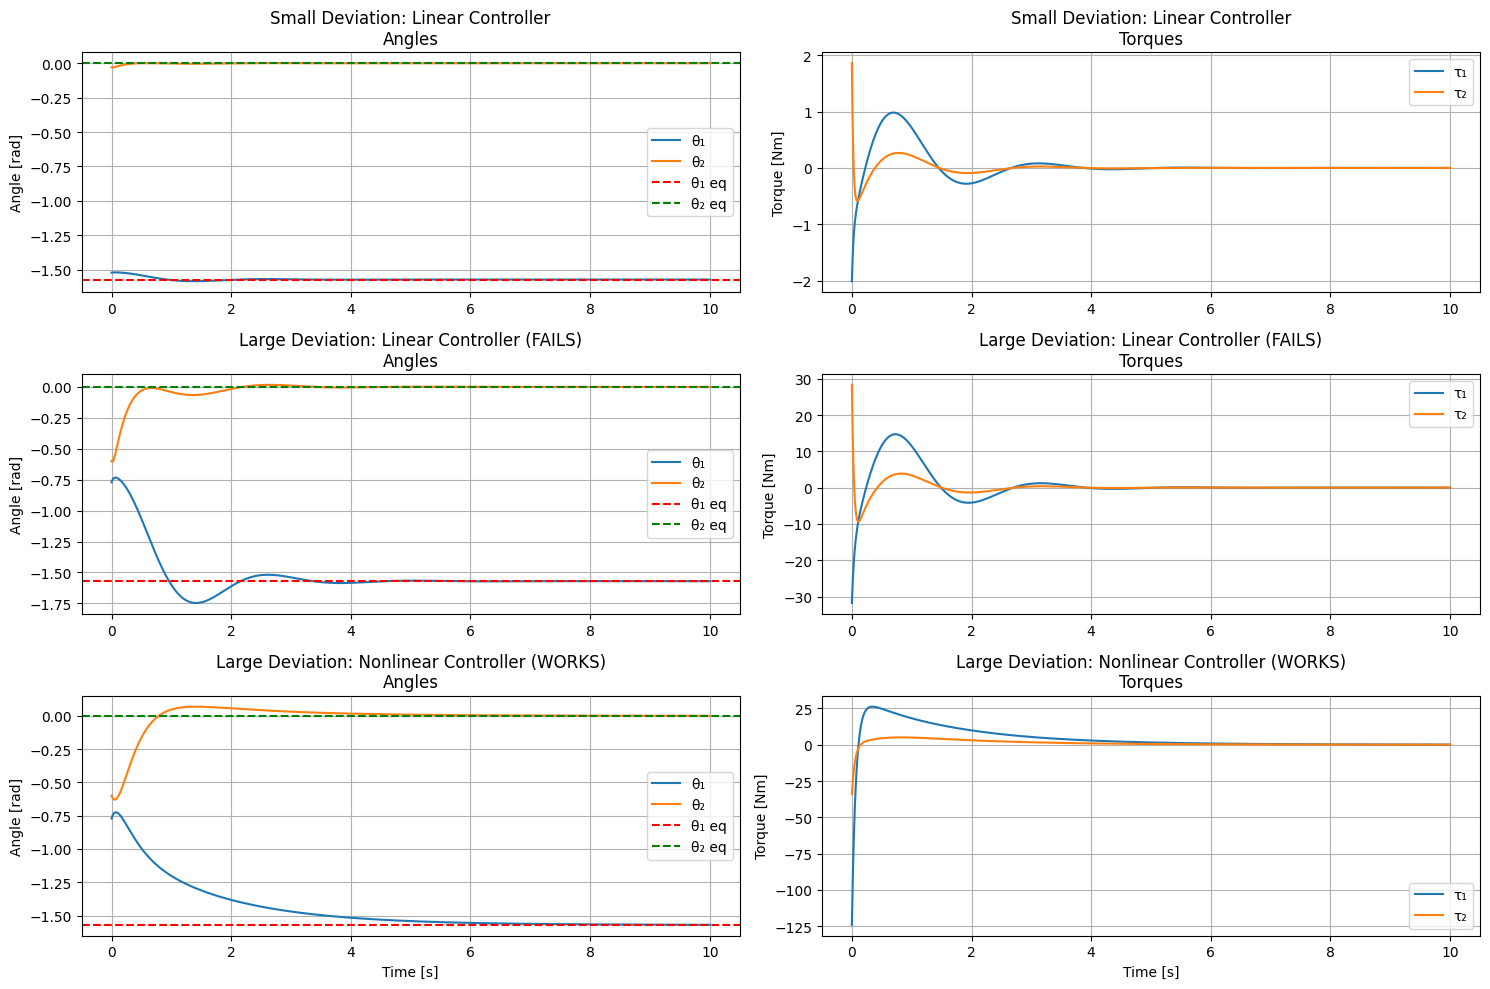

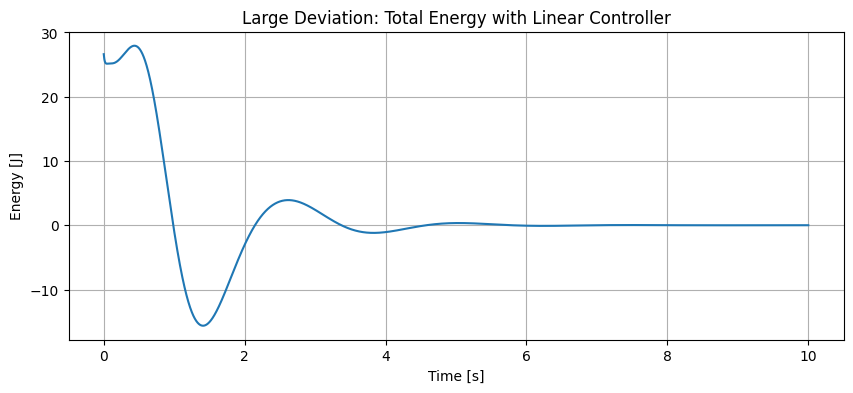

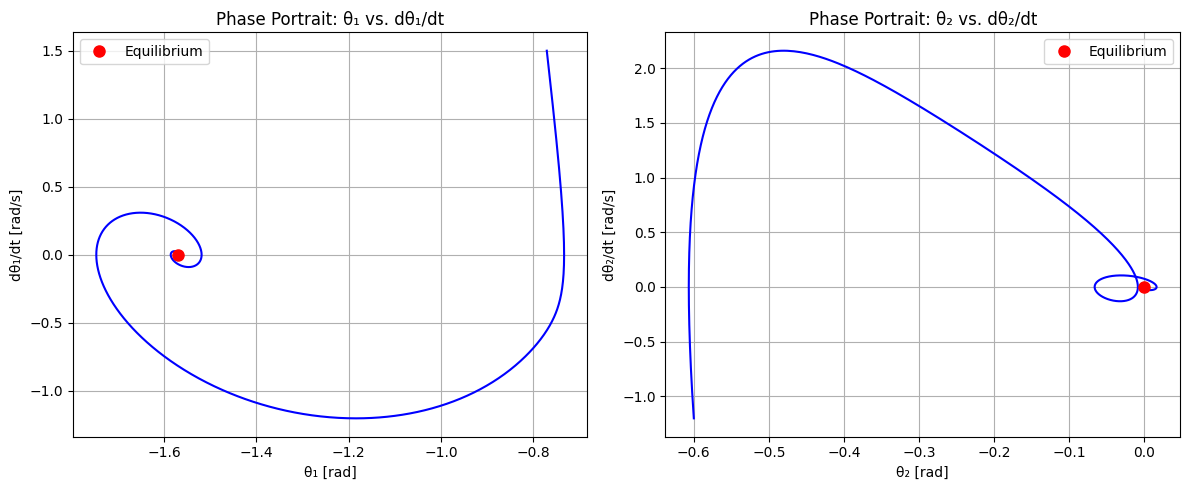

In [5]:
import numpy as np
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt

# -------------------------------
# Parameters
# -------------------------------
L1, L2 = 1.0, 0.8
m1, m2 = 2.0, 1.5
g = 9.81

theta_eq = np.array([-np.pi/2, 0.0])
x_eq = np.array([theta_eq[0], theta_eq[1], 0.0, 0.0])
tau_eq = np.array([0.0, 0.0])

# -------------------------------
# Dynamics
# -------------------------------
def M_matrix(theta):
    th1, th2 = theta
    c2 = np.cos(th2)
    m11 = (m1+m2)*L1**2 + m2*L2**2 + 2*m2*L1*L2*c2
    m12 = m2*L2**2 + m2*L1*L2*c2
    m22 = m2*L2**2
    return np.array([[m11, m12],[m12, m22]])

def C_matrix(theta, theta_dot):
    th1, th2 = theta
    t1dot, t2dot = theta_dot
    s2 = np.sin(th2)
    h = m2*L1*L2*s2
    c11 = -2*h*t2dot
    c12 = -h*t2dot
    c21 = h*t1dot
    return np.array([[c11, c12],[c21, 0.0]])

def G_vector(theta):
    th1, th2 = theta
    g1 = (m1+m2)*g*L1*np.cos(th1) + m2*g*L2*np.cos(th1+th2)
    g2 = m2*g*L2*np.cos(th1+th2)
    return np.array([g1, g2])

def theta_ddot(theta, theta_dot, tau):
    M = M_matrix(theta)
    C = C_matrix(theta, theta_dot)
    G = G_vector(theta)
    rhs = tau - C.dot(theta_dot) - G
    return np.linalg.solve(M, rhs)

def f_state(x, tau):
    theta = x[:2]
    thdot = x[2:]
    thdd = theta_ddot(theta, thdot, tau)
    return np.hstack([thdot, thdd])

# -------------------------------
# Linearization
# -------------------------------
eps = 1e-6
n = 4
A, B = np.zeros((4,4)), np.zeros((4,2))
x0, tau0 = x_eq.copy(), tau_eq.copy()

for i in range(n):
    dx = np.zeros(n); dx[i] = eps
    f_plus = f_state(x0+dx, tau0)
    f_minus = f_state(x0-dx, tau0)
    A[:,i] = (f_plus-f_minus)/(2*eps)

for i in range(2):
    dt = np.zeros(2); dt[i] = eps
    f_plus = f_state(x0, tau0+dt)
    f_minus = f_state(x0, tau0-dt)
    B[:,i] = (f_plus-f_minus)/(2*eps)

# Check eigenvalues (should be purely imaginary)
eigvals = np.linalg.eigvals(A)
print(f"Eigenvalues of A: {eigvals}")
print(f"Real parts: {np.real(eigvals)}")
print("This confirms the equilibrium is non-hyperbolic (real parts ≈ 0)")

# LQR
Q = np.diag([100, 100, 10, 10])
R = np.eye(2) * 0.1
P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ (B.T @ P)

# -------------------------------
# RK4 integrator
# -------------------------------
def rk4_step(x, tau_func, dt, t):
    k1 = f_state(x, tau_func(x, t))
    k2 = f_state(x + 0.5*dt*k1, tau_func(x + 0.5*dt*k1, t + 0.5*dt))
    k3 = f_state(x + 0.5*dt*k2, tau_func(x + 0.5*dt*k2, t + 0.5*dt))
    k4 = f_state(x + dt*k3, tau_func(x + dt*k3, t + dt))
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# -------------------------------
# Reference trajectory (regulation to equilibrium)
# -------------------------------
def reference(t):
    # Regulation to equilibrium
    return x_eq.copy()

def tau_linear_feedback(x, t):
    x_d = reference(t)
    z = x - x_d  # tracking error
    return -K.dot(z)

def tau_nonlinear_feedback(x, t):
    # Computed torque (feedback linearization)
    x_d = reference(t)
    theta = x[:2]
    thdot = x[2:]
    
    # Feedback linearization
    M = M_matrix(theta)
    C = C_matrix(theta, thdot)
    G = G_vector(theta)
    
    # Linear control law
    u = -K.dot(x - x_d)
    
    # Nonlinear compensation
    return M.dot(u) + C.dot(thdot) + G

# -------------------------------
# Simulation
# -------------------------------
def simulate(x0, tau_func, t_final=10.0, dt=0.002):
    steps = int(t_final/dt)
    tvec = np.linspace(0, t_final, steps+1)
    xs = np.zeros((steps+1, 4))
    taus = np.zeros((steps+1, 2))
    xs[0] = x0
    taus[0] = tau_func(x0, 0)
    x = x0.copy()
    
    for i, t in enumerate(tvec[:-1]):
        x = rk4_step(x, tau_func, dt, t)
        xs[i+1] = x
        taus[i+1] = tau_func(x, t+dt)
    
    return tvec, xs, taus

# -------------------------------
# Compare small vs. large deviations with both controllers
# -------------------------------
# Initial conditions
x0_small = x_eq + np.array([0.05, -0.03, 0.1, -0.1])        # small deviation
x0_large = x_eq + np.array([0.8, -0.6, 1.5, -1.2])          # large deviation

# Simulate all cases
print("Simulating small deviation with linear controller...")
t1, xs1, taus1 = simulate(x0_small, tau_linear_feedback)

print("Simulating large deviation with linear controller...")
t2, xs2, taus2 = simulate(x0_large, tau_linear_feedback)

print("Simulating large deviation with nonlinear controller...")
t3, xs3, taus3 = simulate(x0_large, tau_nonlinear_feedback)

# -------------------------------
# Plot results
# -------------------------------
plt.figure(figsize=(15, 10))

# Plot 1: Small deviation with linear controller
plt.subplot(3, 2, 1)
plt.plot(t1, xs1[:, 0], label='θ₁')
plt.plot(t1, xs1[:, 1], label='θ₂')
plt.axhline(y=theta_eq[0], color='r', linestyle='--', label='θ₁ eq')
plt.axhline(y=theta_eq[1], color='g', linestyle='--', label='θ₂ eq')
plt.title('Small Deviation: Linear Controller\nAngles')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(t1, taus1[:, 0], label='τ₁')
plt.plot(t1, taus1[:, 1], label='τ₂')
plt.title('Small Deviation: Linear Controller\nTorques')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid(True)

# Plot 2: Large deviation with linear controller (FAILS)
plt.subplot(3, 2, 3)
plt.plot(t2, xs2[:, 0], label='θ₁')
plt.plot(t2, xs2[:, 1], label='θ₂')
plt.axhline(y=theta_eq[0], color='r', linestyle='--', label='θ₁ eq')
plt.axhline(y=theta_eq[1], color='g', linestyle='--', label='θ₂ eq')
plt.title('Large Deviation: Linear Controller (FAILS)\nAngles')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(t2, taus2[:, 0], label='τ₁')
plt.plot(t2, taus2[:, 1], label='τ₂')
plt.title('Large Deviation: Linear Controller (FAILS)\nTorques')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid(True)

# Plot 3: Large deviation with nonlinear controller (WORKS)
plt.subplot(3, 2, 5)
plt.plot(t3, xs3[:, 0], label='θ₁')
plt.plot(t3, xs3[:, 1], label='θ₂')
plt.axhline(y=theta_eq[0], color='r', linestyle='--', label='θ₁ eq')
plt.axhline(y=theta_eq[1], color='g', linestyle='--', label='θ₂ eq')
plt.title('Large Deviation: Nonlinear Controller (WORKS)\nAngles')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(t3, taus3[:, 0], label='τ₁')
plt.plot(t3, taus3[:, 1], label='τ₂')
plt.title('Large Deviation: Nonlinear Controller (WORKS)\nTorques')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# Energy analysis for the failing case
# -------------------------------
def total_energy(x):
    theta = x[:2]
    thdot = x[2:]
    M = M_matrix(theta)
    T = 0.5 * thdot.dot(M.dot(thdot))  # Kinetic energy
    V = -G_vector(theta).dot(theta)    # Potential energy (relative to equilibrium)
    return T + V

# Calculate energy for the failing case
energy2 = [total_energy(x) for x in xs2]

plt.figure(figsize=(10, 4))
plt.plot(t2, energy2)
plt.title('Large Deviation: Total Energy with Linear Controller')
plt.xlabel('Time [s]')
plt.ylabel('Energy [J]')
plt.grid(True)
plt.show()

# -------------------------------
# Phase portrait for the failing case
# -------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(xs2[:, 0], xs2[:, 2], 'b-')
plt.plot(x_eq[0], x_eq[2], 'ro', markersize=8, label='Equilibrium')
plt.title('Phase Portrait: θ₁ vs. dθ₁/dt')
plt.xlabel('θ₁ [rad]')
plt.ylabel('dθ₁/dt [rad/s]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xs2[:, 1], xs2[:, 3], 'b-')
plt.plot(x_eq[1], x_eq[3], 'ro', markersize=8, label='Equilibrium')
plt.title('Phase Portrait: θ₂ vs. dθ₂/dt')
plt.xlabel('θ₂ [rad]')
plt.ylabel('dθ₂/dt [rad/s]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()